# Graph-Based Learning for Leak Detection in WDNs

> Garðar Örn Garðarsson <br>
Integrated Machine Learning Systems, 2020-21 <br>
*Department of Electronic & Electrical Engineering* <br>
University College London

This notebook implements a statistical leak detection method on the output of two graph-neural networks.

<img src="studies/figs/method.png" alt="Drawing" style="height: 350px;"/>

We pick up the threads starting with two graph-signals, $\hat{y}_p(t)$ and $\hat{y}_r(t)$, i.e. predicted and reconstructed pressure scenes, complete graph signals, that have been generated in another notebook using `GPU` computing power.

The signals are contained in `.csv` files, `2018_predictions.csv`, `2018_reconstructions.csv`, etc. which we load and compute prediction errors from (estimation errors).

We then move on to applying statistical methods on the estimation errors for fault detection.

From that, we extract leaky pipe candidates.

<a id='toc'></a>
# Table of Contents:
1. [Create a Graph form the Hydraulic Simulation Model](#makegraph)<br>
    1.1 [Graph Visualisation](#visualisation) <br>
2. [Read in Predictions and Reconstructions](#readscale)
3. [Calculate Estimation Error](#estimationerror) <br>
    3.1 [Nodal Estimation Error](#nodal_error) <br>
    3.2 [Edge-Wise Estimation Error](#edge_error) <br>
4. [Leak Detection from Estimation error](#detection)<br>
    4.1 [Institut de Robòtica i Informàtica industrial - Spanish Paper](#iri) <br>
    4.2 [Boem et al. - Residual Analysis](#boem) <br>
    
    >4.2.1 [Pre-Processing by Mean-Removal](#pre-process) <br>
    >4.2.2 [Method for Filtering Duplicate Detections](#filter) <br>
    >4.2.3 [Detecting Leakages with Residual Analysis](#detecting-leakages) <br>

<a id='makegraph'></a>
*Back to [Table of Contents](#toc)*

<img src="studies/figs/graph.png" alt="Drawing" style="height: 100px;"/>

## 1. Create a Graph from the Hydraulic Simulation Model

The hydraulic simulation model is an `EPANET` software model. <br>
To work with its graph representation in `python`, we convert the `EPANET` model file (`*.inp`) to a `networkx` graph using the `epynet` library. <br>
Having done so, we may convert the `epynet` object to a `networkx` graph using a custom built function in the `utils.epanet_loader` script, namely `get_nx_graph`.

In [1]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from utils.helpers import discoverNeighbourhood, pipeByneighbourLookup, determineWindowSize
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress `FutureWarnings``

# Runtime configuration, paths, etc. 
path_to_wdn     = './data/L-TOWN.inp'     # Where is the EPANET .inp file stored?
path_to_data    = './data/l-town-data/'   # Where are the pressure measurement files stored
weight_mode     = 'pipe_length'           # How should the graph edges be weighted?
self_loops      = False                   # Should there be self loops on the observed nodes?
scaling         = 'minmax'                # How should the pressure measurements be scaled?
model_name      = 'l-town-chebnet-'   + weight_mode +'-' + scaling + '{}'.format('-self_loop' if self_loops else '')
last_model_path = './studies/models/' + model_name  + '-1.pt'
last_log_path   = './studies/logs/'   + model_name  + '-1.csv' 

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

<a id='visualisation'></a>
*Back to [Table of Contents](#toc)*

### 1.1 Graph Visualisation

Having loaded the `EPANET` model to a `networkx` graph, we may generate a rendering of it using the `nx.draw` functionality.<br>
Notice how the positional attributes (the `pos` variable), that are extracted in the `get_nx_graph()` custom built function in the last step, are passed to the `nx.draw` function. <br>
This is necessary to assume the node's *location* within the rendering.

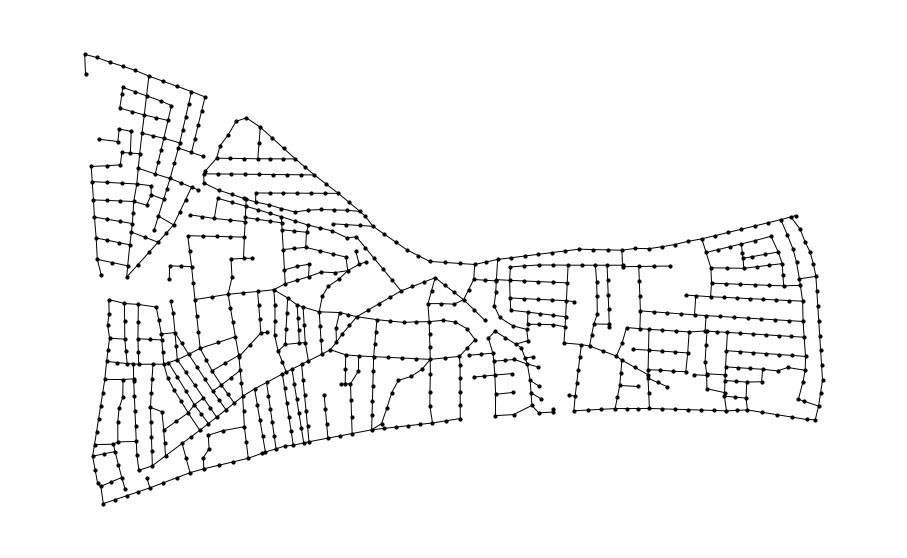

In [2]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,10), sharex=True, sharey=True) 

# Visualise the the model using our visualisation utility
ax = nx.draw(G, pos=pos, node_color='black', node_size=10)

*et voilà !* 🎉

<a id='readscale'></a>
*Back to [Table of Contents](#toc)*

<img src="studies/figs/load.png" alt="Drawing" style="height: 100px;"/>

## 2. Read in Predictions and Reconstructions

In a different notebook, using `GPU` computing power, two `.csv` files have been generated. <br>
The files contain: 

1. Pressure predictions, created with a GNN from a window of previous sparse pressure measurement inputs 
2. Pressure reconstructions, generated with a GNN from current pressure measurement observations

The `.csv` files span **complete** pressure scenes in the network, i.e., the predicted and reconstructed pressure at **every node** in the network, for **every 5 minute timestep** in the years 2018, and 2019.

Let's create a small function to load the `.csv` files into `Pandas DataFrames`

In [3]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df         = pd.read_csv(filename, index_col='Unnamed: 0')      # Read CSV
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns] # Rename columns, 'n1', 'n2', ... 'n782'
    df         = df*scale+bias                                      # Rescale data to original interval of data given a scaling and bias factor
    df.index   = pd.date_range(start=start_date,                    # Set index as a Pandas datetime string
                               periods=len(df),
                               freq = '5min')
    return df

The *predictive* graph-neural network (GNN), used a window of $3$ sparse pressure measurement observations, i.e., the observed pressures at times $(t-1), (t-2), (t-3)$, to predict a complete pressure scenario at $(t)$.

The data is sampled with a `5 minute` sampling rate in the challenge.

As we need $3$ observations before making our first prediction, we need to slice some missing values, `NaN`s, from the top of our dataframe once loaded. 

In [4]:
n_timesteps = 3                                              # Timesteps, t-1, t-2...t-n used to predict pressure at t
sample_rate = 5                                              # Minutes sampling rate of data
offset      = pd.DateOffset(minutes=sample_rate*n_timesteps) # We require n_timesteps of data for our first prediction

Load predictions, here, in my local workspace, they are contained within the working directory, i.e directly at:

`./2018_predictions.csv` &   $\gets$ *The **historical** dataset* <br>
`./2019_predictions.csv`     $\gets$ *The **test** dataset*

In [5]:
predictions = read_prediction(filename='./2018_predictions.csv',
                              scale   = 1,
                              bias    = 0,
                              start_date=pd.Timestamp('2018-01-01 00:00:00') + offset)

Load reconstructions

In [6]:
reconstructions = read_prediction(filename='./2018_reconstructions.csv',
                                  scale   = 1,
                                  bias    = 0,
                                  start_date=pd.Timestamp('2018-01-01 00:00:00'))             # <- Notice, no offset

Information about the leakages is contained in `.csv` files that's provided with the competition data, here, in my local workspace, this is contained under:

`./data/l-town-data/2018_Leakages.csv`

In [7]:
leakages       = pd.read_csv('./data/l-town-data/2018_Leakages.csv',decimal=',',sep=';',index_col='Timestamp')
leakages.index = reconstructions.index # Fix the index column timestamp format

Let's get a slight feeling for the data we've loaded:

**1. Predicted nodal pressures:**

In [8]:
# First prediction
predictions.iloc[0:1]

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-01-01 00:15:00,0.058964,0.07527,0.079275,0.178351,0.234102,0.123902,0.04138,0.249358,0.149831,0.049367,...,0.559117,0.527276,0.552916,0.411664,0.48091,0.433141,0.436825,0.465094,0.500366,0.490234


In [9]:
# Last prediction
predictions.iloc[-1:]

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-12-31 23:55:00,0.058128,0.074434,0.078435,0.176993,0.232744,0.122789,0.040862,0.2477,0.14746,0.048462,...,0.554595,0.523485,0.54936,0.404692,0.474405,0.428408,0.432252,0.460359,0.495082,0.48505


**2. Reconstructed nodal pressures:**

In [10]:
# First reconstruction
reconstructions.iloc[0:1]

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-01-01,0.076338,0.071921,0.078935,0.173683,0.233531,0.12438,0.017961,0.252762,0.156919,0.03012,...,0.558562,0.527209,0.550082,0.415958,0.482246,0.433854,0.439708,0.465652,0.501896,0.491482


In [11]:
# Last reconstruction
reconstructions.iloc[-1:]

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-12-31 23:55:00,0.075175,0.070779,0.077722,0.172766,0.23104,0.123463,0.01748,0.250135,0.155721,0.029259,...,0.556915,0.525173,0.548241,0.413568,0.480571,0.432236,0.438068,0.464034,0.500098,0.489779


**3. Pipe leakages**

In [12]:
# First leakage label data
leakages.iloc[0:1]

,p31,p158,p183,p232,p257,p369,p427,p461,p538,p628,p654,p673,p810,p866
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Last leakage label data
leakages.iloc[-1:]

,p31,p158,p183,p232,p257,p369,p427,p461,p538,p628,p654,p673,p810,p866
2018-12-31 23:55:00,0.0,0.0,0.0,0.0,6.79,0.0,5.05,0.0,0.0,0.0,5.45,0.0,6.87,0.0


<a id='estimationerror'></a>
*Back to [Table of Contents](#toc)*

<img src="studies/figs/calculate.png" alt="Drawing" style="height: 100px;"/>

## 3. Calculate Estimation Error
It's time to calculate estimation errors which form the basis of our leak detection approach.

<a id='nodal_error'></a>
*Back to [Table of Contents](#toc)*

### 3.1 Nodal Estimation Error 
As we now have complete predicted pressure scenarios for our water distribution network, i.e. a predicted pressure for every node $u$ in the network, $\hat{y}_{p,u}(t)$, and similarly a reconstructed node-wise pressure scenario, $\hat{y}_{r,u}(t)$, we may calculate the node-wise estimation error as:

\begin{equation}
r_u(t) = \hat{y}_{p,u}(t) - \hat{y}_{r,u}(t)
\end{equation}

In [14]:
nodal_estimation_error = (predictions-reconstructions).copy().dropna()

Let's verify the header of our dataframe

In [15]:
nodal_estimation_error.head()

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-01-01 00:15:00,-0.017641,0.003056,-0.000031,0.004291,-0.000198,-0.000823,0.023287,-0.004161,-0.007492,0.019002,...,-0.001437,-0.002313,0.000642,-0.006994,-0.003561,-0.002742,-0.004911,-0.002609,-0.003755,-0.003404
2018-01-01 00:20:00,-0.017664,0.003055,-0.000012,0.004465,0.000008,-0.000828,0.023291,-0.003782,-0.007594,0.019083,...,0.001091,0.000495,0.003236,-0.003502,-0.000606,-0.000157,-0.002398,-0.000028,-0.001001,-0.000705
2018-01-01 00:25:00,-0.017753,0.002838,-0.000178,0.004289,-0.000259,-0.000985,0.023217,-0.004092,-0.007616,0.018941,...,-0.001129,-0.002025,0.000815,-0.006475,-0.003240,-0.002456,-0.004684,-0.002310,-0.003497,-0.003137
2018-01-01 00:30:00,-0.017836,0.002793,-0.000205,0.004256,-0.000404,-0.001025,0.023135,-0.004144,-0.007446,0.018840,...,-0.002300,-0.003335,-0.000423,-0.007891,-0.004070,-0.003432,-0.005673,-0.003295,-0.004570,-0.004229
2018-01-01 00:35:00,-0.017850,0.002842,-0.000109,0.004408,-0.000279,-0.000902,0.023200,-0.004052,-0.007295,0.018887,...,-0.000664,-0.001526,0.001258,-0.005747,-0.002326,-0.001738,-0.003974,-0.001577,-0.002677,-0.002387


<a id='edge_error'></a>
*Back to [Table of Contents](#toc)*

### 3.2 Edge-Wise Estimation Error
The objective however is to point to a leaky **pipe**, but the pipes are interpreted as edges in the graph.<br>
We can thus aim to convert the *nodal estimation error* into an *edge wise estimation error*.<br>
Consider an arbitrary edge $j$, that is connected by nodes $u$ and $v$. <br>
Its estimation error may be defined as the absolute difference in the connecting node's estmiation error, namely: 

\begin{equation}
r_j(t) = |r_u(t) - r_v(t)|
\end{equation}

For clarity, consider the following simple graph and the edge-wise estimation error it yields:

<img src="studies/figs/edge_residual.svg" alt="Drawing" style="height: 200px;"/>

So, let's generate a `DataFrame` with this information. <br>
We first need some tools to interpret the relationship of nodes. <br>
For this, we create a dictionary of the form `{'pipe' : [node1, node2]}`, by iterating through all nodes in the graph $G$.<br>
For each node, we iterate through the neighbouring nodes and their respective connecting edges. <br>
We set the connecting edge as a key in a dictionary, and then set the values pertaining to that key as a list of: 

1. The current node under investigation
2. The neighbour connecting the node via the connecting edge

Namely:

In [16]:
neighbours_by_pipe = {}

# For every node in the graph
for node in G:
    # We iterate through a dictionary of {neighbours : connecting_edges}
    for neighbour, connecting_edge in G[node].items():
        
        # If a connecting edge is pointing to the node under investigation, i.e. we encounter a self-loop
        if connecting_edge['name'] == 'SELF':    
            # We skip it
            continue    
            
        # Otherwise
        else:
            # We add an entry to our dictionary, with the name of the connecting edge, pointing to the names of the 
            # node under investigation and its neighbour
            neighbours_by_pipe[connecting_edge['name']] = [node, neighbour]

In [17]:
 neighbours_by_pipe

{'p253': [347, 1],
 'p5': [3, 2],
 'p259': [352, 2],
 'p261': [353, 3],
 'p12': [9, 4],
 'p241': [8, 5],
 'p264': [355, 5],
 'p7': [9, 6],
 'p267': [357, 6],
 'p11': [10, 7],
 'p258': [351, 7],
 'p269': [358, 7],
 'p242': [11, 8],
 'p272': [360, 8],
 'p246': [344, 10],
 'p260': [352, 10],
 'p275': [362, 10],
 'p243': [13, 11],
 'p278': [364, 11],
 'p6': [14, 12],
 'p266': [356, 12],
 'p244': [17, 13],
 'p281': [366, 13],
 'p14': [16, 14],
 'p268': [357, 14],
 'p15': [16, 15],
 'p247': [344, 15],
 'p284': [368, 15],
 'p16': [18, 16],
 'p245': [21, 17],
 'p286': [369, 17],
 'p17': [20, 18],
 'p18': [24, 18],
 'p250': [345, 19],
 'p277': [363, 19],
 'p289': [371, 19],
 'p252': [23, 20],
 'p274': [361, 20],
 'p291': [372, 20],
 'p19': [25, 21],
 'p293': [373, 21],
 'p8': [30, 22],
 'p271': [359, 22],
 'p295': [374, 22],
 'p251': [31, 23],
 'p280': [365, 23],
 'p299': [377, 23],
 'p248': [346, 24],
 'p301': [378, 24],
 'p20': [28, 26],
 'p283': [367, 26],
 'p300': [377, 26],
 'p13': [31, 27

We also create its inverse

In [18]:
pipe_by_neighbours = { str(neighbour_list) : pipe for pipe , neighbour_list in neighbours_by_pipe.items()}

Nice, so with this keyed dictionary, we may create a dictionary of `{'pipe' : pd.Series}`, where the `pd.Series` is the absolute difference of the node estimation error. 

We simply, iterate through the items of the `neighbours_by_pipe` dictionary, which returns:

1. The name of the `pipe`
2. A list of two `nodes`, i.e., `[node1, node2]`

We then create an entry in an empty dictionary, where the `key` refers to the `pipe`, and the `value` assigned to it is the difference of the `node1` and `node2` columns in our previously created `nodal_estimation_error` `DataFrame`!

Finally, we convert this dictionary of `pd.Series` into a `pd.DataFrame`, where the dictionary key is set as the column.

**Let's go!** 🧠🏃

In [19]:
# Initialise an empty dictionary
edge_estimation_error = {}

# Iterate through the relationship dictionary items, the keys are the pipe names and the values are list of nodes
for pipe,nodes in neighbours_by_pipe.items():
    
    # Extract the node names in string format instead of integers
    node_1 = 'n' + str(nodes[0])
    node_2 = 'n' + str(nodes[1])
    
    # Add an entry to the dictionary, the key is the pipe name, and the value is the absolute difference 
    # of the columns 'node1' and 'node2' in our previous nodal_estimation_error DataFrame
    edge_estimation_error[pipe] = nodal_estimation_error[node_1] - nodal_estimation_error[node_2]
    
# Convert the dictionary of Pandas Series into a DataFrame
edge_estimation_error = pd.DataFrame(edge_estimation_error)

Verify the header

In [20]:
edge_estimation_error.head()

,p253,p5,p259,p261,p12,p241,p264,p7,p267,p11,...,p876,p879,p880,p881,p882,p883,p886,p887,p898,p901
2018-01-01 00:15:00,-0.003265,-0.003087,-0.000375,-0.005338,-0.011782,-0.003963,0.004053,-0.006668,-0.002669,-0.004286,...,0.002706,0.000278,0.001203,0.003723,-0.005058,0.002782,0.002344,-0.001008,-0.002169,-0.001146
2018-01-01 00:20:00,-0.003261,-0.003067,-0.000324,-0.005438,-0.012059,-0.003790,0.004257,-0.006766,-0.002552,-0.004208,...,0.002399,0.000263,0.001249,0.003688,-0.004795,0.002625,0.002416,-0.001100,-0.002240,-0.000973
2018-01-01 00:25:00,-0.003274,-0.003016,-0.000281,-0.005394,-0.011905,-0.003833,0.004303,-0.006631,-0.002622,-0.004276,...,0.002793,0.000310,0.001122,0.003778,-0.004959,0.002591,0.002360,-0.000970,-0.002229,-0.001187
2018-01-01 00:30:00,-0.003314,-0.002998,-0.000336,-0.005460,-0.011702,-0.003740,0.004391,-0.006421,-0.002658,-0.004295,...,0.002970,0.000387,0.001254,0.003423,-0.004932,0.002533,0.002142,-0.000924,-0.002242,-0.001275
2018-01-01 00:35:00,-0.003300,-0.002951,-0.000370,-0.005568,-0.011703,-0.003773,0.004395,-0.006393,-0.002599,-0.004313,...,0.002888,0.000361,0.001247,0.003579,-0.004889,0.002457,0.002324,-0.001081,-0.002237,-0.001100


✅ Mission accomplished

<a id='detection'></a>
*Back to [Table of Contents](#toc)*

<img src="studies/figs/detection.png" alt="Drawing" style="height: 100px;"/>

## 4. Leak Detection from Estimation Error

Herein, we'll look into two methods for leak detection from the nodal- and edge-wise estimation errors.

1. The first is based on fitting a best line through a point cloud of predicted and reconstructed pressure scenarios, and calculating the *least-squares distances* between predicted and reconstructed pressures.

2. The latter involves calculating a threshold and 

<a id='iri'></a>
*Back to [Table of Contents](#toc)*

### 4.1  Institut de Robòtica i Informàtica industrial - Spanish Paper

Suspected leaky nodes: [ 36 345]
0.005098187034707646


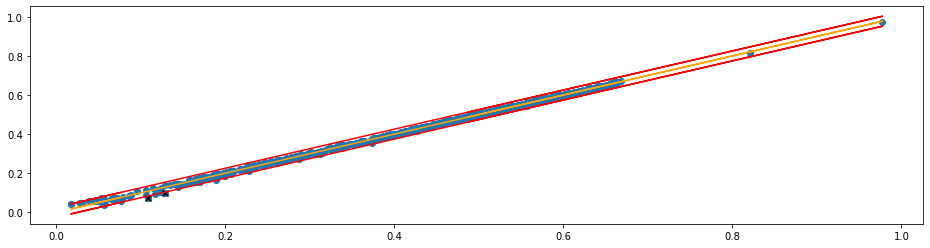

In [21]:
from sklearn.linear_model import LinearRegression

timestamp = '2018-10-06 02:35:00'
threshold = 5

x = reconstructions.loc[timestamp].to_numpy().reshape([-1,1])
y = predictions.loc[timestamp].to_numpy().reshape([-1,1])

reg = LinearRegression()
reg.fit(x,y)

y_pred = reg.predict(x)
res    = y_pred - y

print("Suspected leaky nodes: {}".format(np.add(np.where(res>threshold*np.std(res))[0],1)))
print(np.std(res))

plt.figure(figsize=(16,4))

plt.scatter(x,y)                                                                            # Point cloud
plt.plot(x,y_pred,color='orange')                                                           # Fitted line 
plt.plot(x,y_pred+threshold*np.std(res),color='red')                                        # Upper limit
plt.plot(x,y_pred-threshold*np.std(res),color='red')                                        # Lower limit
plt.scatter(x[res>threshold*np.std(res)],y[res>threshold*np.std(res)],marker='x',color='k') # Mark outliers

<a id='boem'></a>
*Back to [Table of Contents](#toc)*

### 4.2  Boem et al. - Residual Analysis
In this method, we define the signal to be assessed as the absolute value of the rolling mean of the 
residual signal, namely:

\begin{equation}
|\bar{r}^{(m)}(k)| = \text{ABS} \left( \frac{1}{m} \sum_{i=0}^{m} S(k-i) \right)
\end{equation}

Now, for the detection threshold, we define it as: 

\begin{equation}
\bar{\rho}^{(m)}(k) = \alpha \bar{\sigma}^{(m)}(k)
\end{equation}

Where:

\begin{equation}
(\bar{\sigma}^{(m),B}(k))^2 = \frac{1}{m} \sum_{j=0}^{m-1} (\sigma^B(k-j))^2
\end{equation}

... or effectively, the threshold is some value $\alpha$ times the rolling standard deviation of the signal for a window of length $m$. 

<a id='pre-process'></a>
*Back to [Table of Contents](#toc)*

#### 4.2.1 Pre-Processing by Mean-Removal
Let's investigate the signal, $S(k)$, for a single arbitrary pipe, `p347`.

<AxesSubplot:>

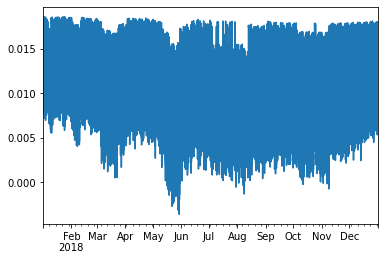

In [22]:
edge_estimation_error['p347'].plot()

and lets visualise what the rolling mean condition to be assessed, $|\bar{r}^{(m)}(k)|$, would look like against the detection threshold, $\bar{\rho}^{(m)}(k) = \alpha \bar{\sigma}^{(m)}(k)$, 

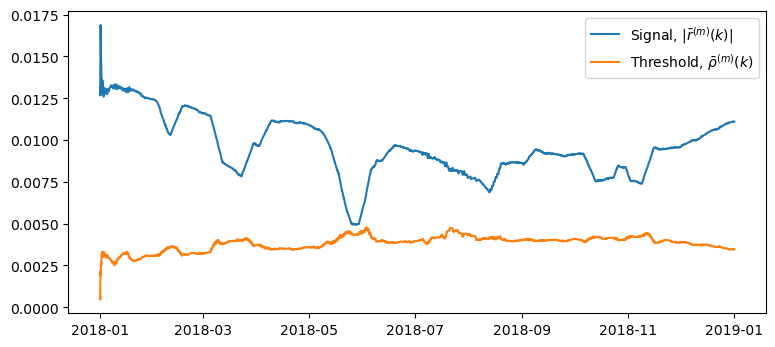

In [23]:
plt.figure(figsize=(9,4),dpi=100)
plt.plot(abs(edge_estimation_error['p347'].rolling('7d').mean()), label=r'Signal, $|\bar{r}^{(m)}(k)|$')
plt.plot(edge_estimation_error['p347'].rolling('7d').std(),       label=r'Threshold, $\bar{\rho}^{(m)}(k)$')
plt.legend()

We see that this makes very little sense, for the entire year, the signal (blue) is above the detection threshold (orange) due to the mean-skewness of the signal. 

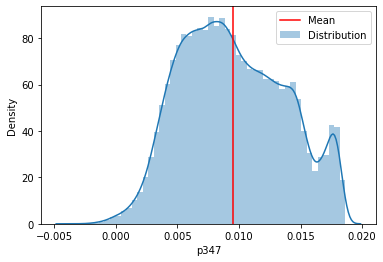

In [24]:
sns.distplot(edge_estimation_error['p347'], label='Distribution')
plt.axvline(x=edge_estimation_error['p347'].mean(), color='red', label='Mean')
plt.legend()
plt.show()

We need to subtract the mean from the signal so that it is set at $0$:

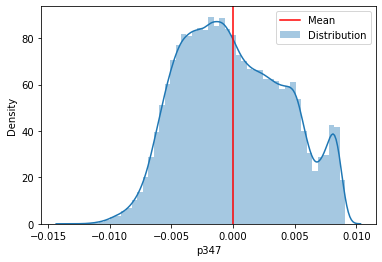

In [25]:
mean_corrected = edge_estimation_error['p347']-edge_estimation_error['p347'].mean()
sns.distplot(mean_corrected, label='Distribution')
plt.axvline(x=mean_corrected.mean(), color='red', label='Mean')
plt.legend()
plt.show()

Which again would yield the following detection:

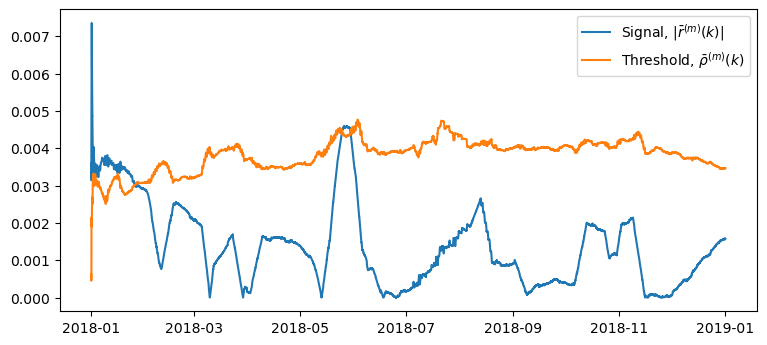

In [26]:
plt.figure(figsize=(9,4),dpi=100)
plt.plot(abs(edge_estimation_error['p347'].rolling('7d').mean()-edge_estimation_error['p347'].mean()), label=r'Signal, $|\bar{r}^{(m)}(k)|$')
plt.plot(edge_estimation_error['p347'].rolling('7d').std(),       label=r'Threshold, $\bar{\rho}^{(m)}(k)$')
plt.legend()


Now, however, we also need to be vary of not biasing the signal with the faulty condition, i.e. when there are leakages. <br>
So, we should only calculate the mean to subtract from signal, under healthy condition of the pipe.

For this, we use the historical data of 2018, and the leakage labelset.

First we extract information about the time in which leakages are present:

In [27]:
leak_timestamps = {}

for leak in leakages:
    leak_timestamps[leak] = leakages.index[leakages[leak]>0]

And define a boundary of pipes affected by the leakage, as those that are within a 6-hop distance from the leak origin.  

We choose $k=6$, as the BattLeDIM challenge penalises detections that are outside $300~m$ from the source of the leakage, and the average pipe length in the network is $50~m$, i.e. $k=6$ should relate to the $300~m$ detection boundary.

In [28]:
# k-hop neighbourhood of a leaky pipe - If a pipe is not within 6-hops from the leak source, it's considered to
# not have been affected by the leakage event
k = 6                                        

fault_times = {}

# First populate the key variable with empty lists, that are the k-hop neighbouring nodes of leaky pipes:
for leaky_pipe in leak_timestamps.keys():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe] = []

Now that we've initialised the dictionary with empty lists, we can again iterate through the `leak_timestamps` and append them to the lists, thereby, taking care of not overwriting recurring nodes:

*Note: recurring nodes, would be nodes that are in the $k$ neighbourhood of more than one leakages*

In [29]:
for leaky_pipe, time in leak_timestamps.items():
    pipes, _ = discoverNeighbourhood(leaky_pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)
    for pipe in pipes:
        fault_times[pipe].append(time)

Let's print some information from what we've done so far.

In [30]:
pipe_with_most_faulty_periods = ''
most_faults_found_in_a_pipe   = 0

for pipe, dt_list in fault_times.items():
    n_faulty_periods = len(dt_list)
    
    if n_faulty_periods > most_faults_found_in_a_pipe:
        pipe_with_most_faulty_periods = pipe
        most_faults_found_in_a_pipe   = n_faulty_periods
        
print('Pipe {} was the {}-hop neighbour to {} leakages'.format(pipe_with_most_faulty_periods,
                                                               k,
                                                               most_faults_found_in_a_pipe))

Pipe p632 was the 6-hop neighbour to 3 leakages


So pipe `p632` was most often affected by leakages, in total on 3 occasions.

Okay, so, let's calculate the mean of pipes whose 6-hop neighbourhood encounters a leakage through the course of 2018, by leaving the faulty periods out of the calculation. <br>
We'll call this variable `faulty_avg`.

In [31]:
faulty_avg = {}
faulty_std = {}

for pipe, dt_list in fault_times.items():
    
    n_faulty_periods = len(dt_list)
    
    # Some ugly hardcoding:
    # I didn't figure out a better way to calculate the mean for different number of events
    # occuring between the pipes. If we're extending the "k-hop" distance that we think of
    # as affecting a pipe, then we must make sure that we add a statement that addresses
    # those number of leakages, e.g. n_faulty_periods == 7 for k-hop distance 20, then
    # add a statement for n_faulty periods == 5, ... == 7.
    if n_faulty_periods == 1:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0])].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0])].std()
        
    if n_faulty_periods == 2:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) ].std()
    if n_faulty_periods == 3:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) ].std()
    if n_faulty_periods == 4:
        faulty_avg[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][3]) ].mean()
        faulty_std[pipe] = edge_estimation_error[pipe][~edge_estimation_error[pipe].index.isin(fault_times[pipe][0]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][1]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][2]) & \
                                                         ~edge_estimation_error[pipe].index.isin(fault_times[pipe][3]) ].std()


And, the other pipes, that were not 6-hop neighbours to any leakages in 2018, we calculate their mean as:

In [32]:
healthy_avg = {}
healthy_std = {}

for pipe in edge_estimation_error:
    if pipe in faulty_avg:
        continue
    else:
        healthy_avg[pipe] = edge_estimation_error[pipe].mean()
        healthy_std[pipe] = edge_estimation_error[pipe].std()

Great, now, let's correct the entire `edge_estimation_error` dataset with the mean under healthy condition, namely:

In [33]:
signal = pd.DataFrame([])
for pipe in edge_estimation_error:
    if pipe in faulty_avg.keys():
        signal[pipe] = (edge_estimation_error[pipe] - faulty_avg[pipe])
    else:
        signal[pipe] = (edge_estimation_error[pipe] - healthy_avg[pipe])

<a id='filter'></a>
*Back to [Table of Contents](#toc)*

#### 4.2.2 Method for Filtering Duplicate Detections
Create a list of all pipes and their corresponding k-hop neighbours

In [34]:
k = 6
k_hop_neighbours = {}

for pipe in edge_estimation_error:
    k_hop_neighbours[pipe], _ = discoverNeighbourhood(pipe, neighbours_by_pipe, pipe_by_neighbours, G, k=k)

Remove self references from the value list

In [35]:
for reference_to_self, neighbours in k_hop_neighbours.items():
    neighbours.remove(reference_to_self)

Finally... after a difficult birth, an approach for filtering duplicate detections! 🧹

In [36]:
def filterDuplicateDetections(leaks, k_hop_neighbours):
    i=0
    while i < len(leaks):                                                 # For every time-entry
        faulty_pipes = set(leaks.iloc[i][leaks.iloc[i]>0].index.tolist()) # Get a set of faulty pipes at time [i]
        if faulty_pipes:                                                  # If the set is not empty
            for pipe in faulty_pipes:                                     # For every pipe in the set
                neighbours = set(k_hop_neighbours[pipe])                  # Look up the neighbourhood
                duplicates = faulty_pipes.intersection(neighbours)        # And define duplicates as faulty ∩ nbors
                if duplicates:                                            # If there are indeed detections in ∩
                    leaks.iloc[i][duplicates] = 0                         # Suppress those detections
                    break                                                 # and break the loop to redetermine faults
                else:                                                     # If no duplicates were found
                    continue                                              # Validate the next faulty pipe
        i+=1                                                              # Proceed to the next timestamp
        if i % 10000 == 0:                                                # Every 10.000th iteration
            print('Verified: {} entries'.format(i))                       # Notify user of progress
            
    # RETURN THE FILTERED RESULTS !
    return leaks

<a id='detecting-leakages'></a>
*Back to [Table of Contents](#toc)*

#### 4.2.3 Detecting Leakages with Residual Analysis
Load the predictions and reconstructions for the test dataset, i.e. `2019`.

In [37]:
tst_predictions = read_prediction(filename='./2019_predictions.csv',
                                  scale   = 1,
                                  bias    = 0,
                                  start_date=pd.Timestamp('2019-01-01 00:00:00') + offset)

In [38]:
tst_reconstructions = read_prediction(filename='./2019_reconstructions.csv',
                                      scale   = 1,
                                      bias    = 0,
                                      start_date=pd.Timestamp('2019-01-01 00:00:00'))         # <- Notice, no offset

Calculate the nodal, and edge-wise residuals as before

In [39]:
tst_nodal_estimation_error = (tst_predictions-tst_reconstructions).copy().dropna()

In [40]:
# Initialise an empty dictionary
tst_edge_estimation_error = {}

# Iterate through the relationship dictionary items, the keys are the pipe names and the values are list of nodes
for pipe,nodes in neighbours_by_pipe.items():
    
    # Extract the node names in string format instead of integers
    node_1 = 'n' + str(nodes[0])
    node_2 = 'n' + str(nodes[1])
    
    # Add an entry to the dictionary, the key is the pipe name, and the value is the absolute difference 
    # of the columns 'node1' and 'node2' in our previous nodal_estimation_error DataFrame
    tst_edge_estimation_error[pipe] = tst_nodal_estimation_error[node_1] - tst_nodal_estimation_error[node_2]
    
# Convert the dictionary of Pandas Series into a DataFrame
tst_edge_estimation_error = pd.DataFrame(tst_edge_estimation_error)

Pre-process signal by removing mean calculated under healthy condition

In [41]:
signal = pd.DataFrame([])
for pipe in tst_edge_estimation_error:
    if pipe in faulty_avg.keys():
        signal[pipe] = (tst_edge_estimation_error[pipe] - faulty_avg[pipe])
    else:
        signal[pipe] = (tst_edge_estimation_error[pipe] - healthy_avg[pipe])

Predict leakages.

In [53]:
windows_to_try  = ['7d']
alphas_to_try   = [ 1 ]
detection_limit = ['6h','12h','1d']
results_dir     = 'studies/detections/revised_detections/'
leaky_pipes     = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Pipes
leaks_detected  = pd.DataFrame([], columns=windows_to_try, index=alphas_to_try) # Table of results - Leaks

# For every window size m
for m in windows_to_try:

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m, sampling_rate='5min')   # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m, min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    # For every alpha to try:
    for alpha in alphas_to_try:
        
        # Limit number of detections
        for sampling_period in detection_limit:
            
            # Print info
            print('o' + '-'*46 +'o')
            print('|' + '{:^46}'.format("Detecting leakages with:")    + '|')
            print('|' + '{:^46}'.format('m:\t'+str(m))                 + '|')
            print('|' + '{:^46}'.format('alpha:'+str(alpha))           + '|')
            print('|' + '{:^46}'.format('alpha:'+str(sampling_period)) + '|')
            print('o' + '-'*46 +'o')

            threshold = alpha*signal.rolling(m,min_per).std().dropna()  # Find the threshold given window m and alpha
            faults = (r_m_k >= threshold).astype('int')                 # Classify faults as those surpassing thrshld
            edges = faults.diff(periods=1).fillna((faults.iloc[0]).astype('int')) # Detect the rising edges

            # FILTER DUPLICATE ENTRIES IN THE FAULT DETECTION BASED ON K-HOP NEIGHBOURHOOD
            #filtered = filterDuplicateDetections(edges, k_hop_neighbours)

            # RESAMPLE DETECTIONS TO 4, 2 AND 1 PER DAY, KEEPING ONLY THE FIRST DETECTION
            filtered = edges.resample(sampling_period).first()

            # Get the timestamps by reading the rising edges
            detections = {}

            for pipe in filtered:
                timestamp = filtered[pipe].index[filtered[pipe]>0] # Rising edge = 1, falling edge = -1
                if timestamp.empty:                                # If the timestamp array is empty, there were no
                    continue                                       # leaks so we continue
                else:                                              # If however it returned a populated array
                    detections[pipe] = timestamp                   # we store those timestamps

            # Generate a result file:
            file_name      = "results_m-{}_alpha-{}_limit-{}.txt".format(m, alpha, sampling_period)
            pipes_detected = len(detections.keys())
            events_found   = 0

            with open(results_dir + file_name, 'w') as results:
                results.write('#linkID, startTime\n')
                for key in detections.keys():
                    for val in detections[key]: 
                        results.write(key + ', ' + str(val)[:-3] + '\n')
                        events_found += 1
                results.close()

            print('Found:\t{} leaks'.format(events_found))
            print('In:\t{} pipes\n'.format(pipes_detected))

            leaky_pipes[   m][alpha] = pipes_detected
            leaks_detected[m][alpha] = events_found

        
leaks_detected.to_csv(results_dir+'leaks_per_m_alpha.csv')
leaky_pipes.to_csv(   results_dir+'pipes_per_m_alpha.csv')

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	7d                     |
|                   alpha:1                    |
|                   alpha:6h                   |
o----------------------------------------------o
Found:	113 leaks
In:	104 pipes

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	7d                     |
|                   alpha:1                    |
|                  alpha:12h                   |
o----------------------------------------------o
Found:	40 leaks
In:	38 pipes

o----------------------------------------------o
|           Detecting leakages with:           |
|                    m:	7d                     |
|                   alpha:1                    |
|                   alpha:1d                   |
o----------------------------------------------o
Found:	30 leaks
In:	29 pipes



In [43]:
def findFaults(signal, m, alpha):

    # Calculate the rolling mean of the signal
    min_per = determineWindowSize(m ,sampling_rate='5min')        # The minimum period before returning a value = m
    r_m_k   = abs(signal.rolling(m,min_per).mean().dropna()) # Calculate the abs rolling mean of the residual

    threshold = alpha*signal.rolling(m,min_per).std().dropna() # Find the threshold given window m and alpha
    faults    = (r_m_k >= threshold).astype('int')                  # Classify faults as those surpassing thrshld
    edges     = faults.diff(periods=1).fillna((faults.iloc[0]).astype('int')) # Detect the rising and falling edges

    # FILTER DUPLICATE ENTRIES IN THE FAULT DETECTION
    filtered = filterDuplicateDetections(edges, k_hop_neighbours)
    
    # Get the timestamps by reading the rising edges
    detections = {}

    for pipe in filtered:
        timestamp = filtered[pipe].index[filtered[pipe]>0]   # Rising edge = 1, falling edge = -1
        if timestamp.empty:                                  # If the timestamp array is empty, there were no
            continue                                         # leaks so we continue
        else:                                                # If however it returned a populated array
            detections[pipe] = timestamp                     # we store those timestamps
    
    return filtered, faults, detections, r_m_k, threshold

In [44]:
def plotDetections(pipe, faults, r_m_k, threshold):
    
    plt.figure(figsize=(16,6))

    plt.plot(r_m_k[pipe], label = 'Signal')
    plt.plot(threshold[pipe], label='Threshold')    
    plt.plot(2e-3*faults[pipe])
    plt.legend()
    plt.show()

In [45]:
filtered, faults, detections, r_m_k, threshold = findFaults(signal, m='7d',alpha=1)

Verified: 10000 entries
Verified: 20000 entries
Verified: 30000 entries
Verified: 40000 entries
Verified: 50000 entries
Verified: 60000 entries
Verified: 70000 entries
Verified: 80000 entries
Verified: 90000 entries
Verified: 100000 entries


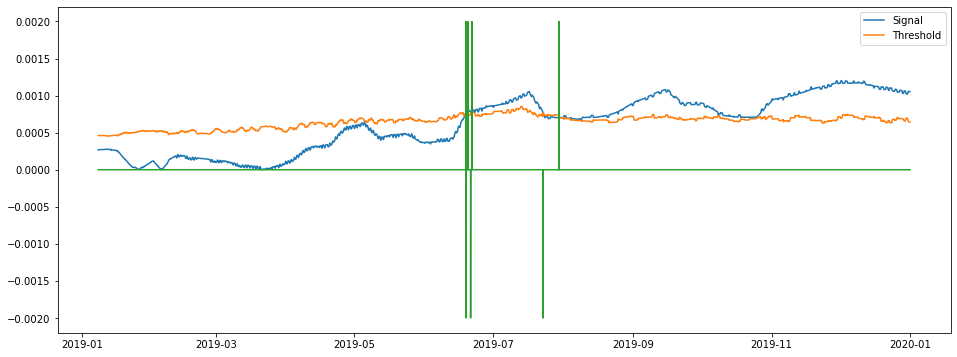

In [46]:
plotDetections('p331', filtered, r_m_k, threshold)